Some Remarks before the code:
- This code matches with tue part II/ of tue visit report in tue Github repository. For a better understanding of the code, it is thus better look at the report.

- Throughout the code, we refer as **"LMI"** the paper "Linearly implicit methods for a semilinear parabolic system arising in
two-phase flows" by GEORGIOS AKRIVIS, DEMETRIOS T. PAPAGEORGIOU and YIORGOS-SOKRATIS SMYRLIS. For more detail, see the report in the Github repository.

# Initialisations and definitions

In [65]:
##Imports
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sklearn.linear_model import LinearRegression



In [66]:
plt.rc('font', size=20) # Set the font size for all the plots 

In [67]:
## Initialisations: quantities and domain (dimensionless variables)

T = 50 #Time 
L_x = 2*np.pi #Length 
epsilon = 0
nu = 1 #nu = 4pi²/L² in m-2

#Number of space/time point, space/time steps
N_x = 100 #Number of space point
N_t = 100*N_x #Number of time point
dx = L_x/N_x #periodic so (N_x-1)dx=L-dx
dt = T/(N_t-1) #Not periodic: (N_t-1)dt=T
print("NB OF SPACE AND TIME POINTS:", N_x, N_t)
print("Time T:", T)

NB OF SPACE AND TIME POINTS: 100 10000
Time T: 50


In [68]:
###Initial conditions & Domain
##Somes functions to use for Initial Condition
def sincos(x, _u_mean, _ampl_c, _ampl_s, _freq_c, _freq_s):
    '''Returns a sinusoidal function of the form h_mean + Acos(f_c t) + Bsin(f_s t).
    Used for periodic Initial Condition.'''
    return _u_mean + _ampl_c*np.cos(_freq_c*x) + _ampl_s*np.sin(_freq_s*x) 

def Poly_1(x, n_1, n_2, n_3):
    '''Return a Polynomial with roots on 0, 1 and L_x. Used also for periodic Initial Condition'''
    return ((x-1)**n_1)*(x**n_2)*((x-L_x)**n_3)


##Domain
Domain_x = np.linspace(0, L_x, N_x, endpoint=False) #Periodic domain: we don't nee the last point (endpoint=False)
print("First and last point of the domain:", Domain_x[0], Domain_x[-1])
print("2pi-dx:", 2*np.pi-dx)


##Initial condition
u_mat = np.zeros((N_t, N_x)) #Matrix of the height. Each line is for a given time from 0 to (N_t-1)*dt
u_mean = 0
mode_fq = 1
ampl_c, ampl_s = 0, 1 #Sinusoidal amplitudes
freq_c, freq_s= mode_fq, mode_fq #Frequencies with respect to L_x (2pi)
u_mat[0,:] = sincos(Domain_x, u_mean, ampl_c, ampl_s, freq_c, freq_s) #initial condition

First and last point of the domain: 0.0 6.220353454107791
2pi-dx: 6.220353454107791


# Fourier Decomposition: tests & definitions


 Shape of the array of frequencies:  (51,)


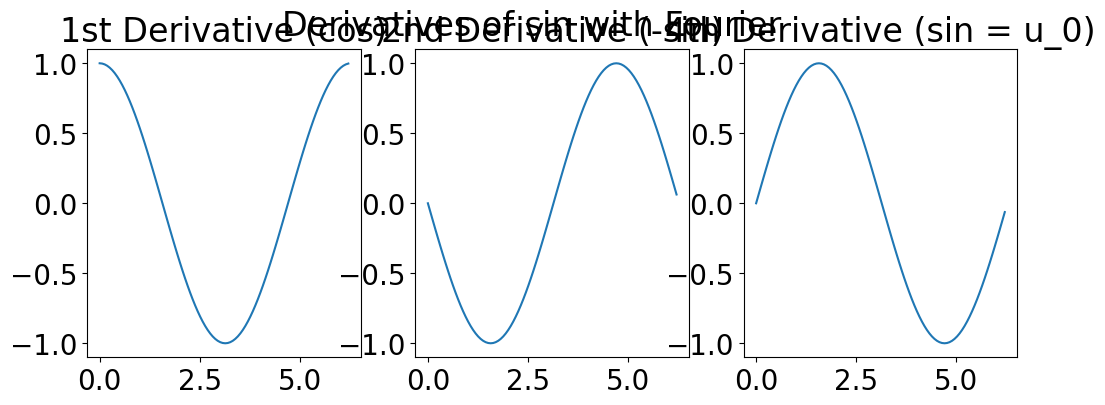

In [69]:
##Test of the differentiation with FFT to see if there is some Gibbs phenomenon 

fq_tab = N_x*np.fft.rfftfreq(N_x) #to justify better after
u_test = np.sin(Domain_x)

print("\n Shape of the array of frequencies: ", fq_tab.shape)
if True:
    fig, ax = plt.subplots(1, 3, figsize = (12,4))


    U_x = np.fft.irfft( (1j *fq_tab)*np.fft.rfft(u_test))
    # print(U_x.real)
    ax[0].plot(Domain_x, U_x.real)
    ax[0].set_title("1st Derivative (cos)")

    U_xx = np.fft.irfft( (1j *fq_tab)**2*np.fft.rfft(u_test))
    # print(U_xx)
    ax[1].plot(Domain_x, U_xx.real)
    ax[1].set_title("2nd Derivative (-sin)")


    U_xxxx = np.fft.irfft( (1j *fq_tab)**4*np.fft.rfft(u_test))
    # print(U_xxxx)
    ax[2].plot(Domain_x, U_xxxx.real)
    ax[2].set_title("4th Derivative (sin = u_0)")

    fig.suptitle("Derivatives of sin with Fourier ")
    plt.show()



Shape of the Fourier matrix: (10000, 51)

 Mean of the initial Function: (-1.5265566588595903e-18+0j)

 Shape of u_c and u_s:  (50,)


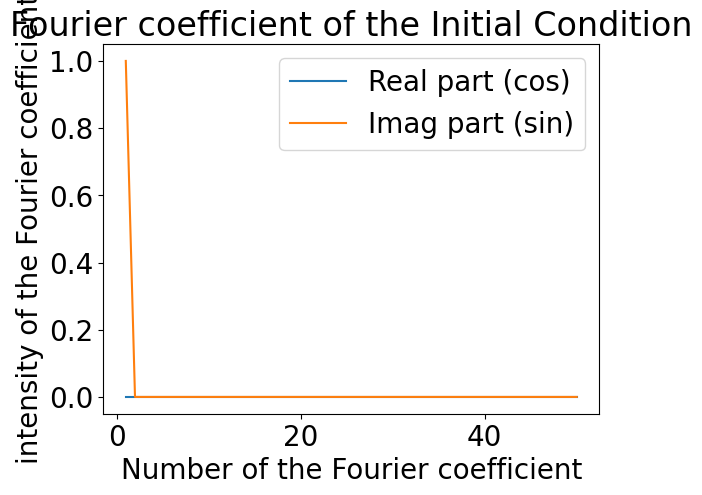

In [70]:
##Definition of the Fourier coefficients H_c & H_s
#Fourier matrix
u_Fourier_mat = np.zeros((N_t, len(fq_tab)), dtype=complex)
u_Fourier_mat[0, :] = np.fft.rfft(u_mat[0, :], norm="forward") 
#scaled to Forward to have a mean at the first coefficient
print("\nShape of the Fourier matrix:", u_Fourier_mat.shape)

#H_c & H_s: sin and cos coefficient of the Fourier transform like LMI paper
print("\n Mean of the initial Function:", u_Fourier_mat[0, 0])
u_c = 2*u_Fourier_mat[0, 1:].real  #See the Obsidian file for justification.
u_s = -2*u_Fourier_mat[0, 1:].imag 
print("\n Shape of u_c and u_s: ", u_c.shape)
M = len(u_c) #Order of trucation


#plot of the IC in frequency domain
plt.plot(fq_tab[1:], u_c, label="Real part (cos)")
plt.plot(fq_tab[1:], u_s, label="Imag part (sin)")
plt.xlabel("Number of the Fourier coefficient")
plt.ylabel("intensity of the Fourier coefficient")
plt.legend()
plt.title("Fourier coefficient of the Initial Condition") #verification for the sinus IC 
plt.show()

In [71]:
### Computation of the non linearity arising in the ODEs to solve (cf LMI)
def F(u_c, u_s, _M=M):
    '''
    Computes the non linear part of the fourier transform of the KS equation (Cf LMI).We suppose 
    here that the mean value of the function is always 0, like the paper. Hence we manipulate only H_s and H_c'

    - input: H_c, H_s: np.array of size _M. Fourier coef of the height of the fluid.
    - output: (F_c, F_s), 2 np.array of size _M which are the non lin part of the cos and sin resp.
    '''

    F_c = np.zeros(_M)
    F_s = np.zeros(_M)

    # Use broadcasting to calculate H_c * H_s and H_c * H_c and H_s * H_s
    u_c_matrix = u_c[:, None]  # Convert to column vector
    u_s_matrix = u_s[:, None]  # same

    u_c_u_s = u_c_matrix * u_s_matrix.T
    u_s_u_c = u_s_matrix * u_c_matrix.T
    u_c_u_c = u_c_matrix * u_c_matrix.T
    u_s_u_s = u_s_matrix * u_s_matrix.T

    m_indices = np.arange(1, _M+1)
    n_indices = np.arange(1, _M+1)

    for j in range(1, _M+1):
        # Find m+n == j
        mask1 = m_indices[None, :] + n_indices[:, None] == j  # Shape (_M+1, _M+1)
        F_s[j-1] += np.sum( (u_c_u_c - u_s_u_s) * mask1)/2
        F_c[j-1] -= np.sum(u_c_u_s* mask1)
        
        # Find m-n == j
        mask2 = m_indices[:, None] - n_indices[None, :] == j  # Shape (_M+1, _M+1)
        F_s[j-1] += np.sum( (u_c_u_c + u_s_u_s) * mask2)
        F_c[j-1] += np.sum( (u_c_u_s - u_s_u_c) * mask2) 
        #watch out: the summation isn't symetric i.e the order of the indices m&n is important

        F_c[j-1] *= j / 2
        F_s[j-1] *= j / 2

    return F_c, F_s


#Tests of F
print("Computation test of F:")
u_c_test = np.array([1, 1, 1]) # supposed to return [ 0. , -1. , -1.5]
u_s_test = np.array([1, 0, 1]) # supposed to return [1. , 2. , 1.5]
print("Test with F", F(u_c_test, u_s_test, _M=3))

print("\nSpeed test for F:")
bool_speed_test = True
if bool_speed_test:
    t_i = time.time()
    F(np.ones(len(u_c)), 2*np.ones(len(u_c)))
    t_f = time.time()
    print("Computation time for F: ", int((t_f-t_i)), "s.")
    print("prevision of the simulation computation time using F:", N_t*(t_f-t_i))

Computation test of F:
Test with F (array([ 0. , -1. , -1.5]), array([1. , 2. , 1.5]))

Speed test for F:
Computation time for F:  0 s.
prevision of the simulation computation time using F: 0.0


# Expression of the lambdas and solving

In [72]:
##Some bool variables to set what to do
bool_calculus_Fourier = True #Use the numerical scheme or not
save = False #Save the Fourier Tranform array or not

bool_scheme_paper = True #Numerical scheme of LMI paper
#Other tested numerical scheme (cf solving part)
bool_scheme_1, bool_scheme_2, bool_scheme_3 = False, False, False 




## Visualisation of the lambdas

1/sqrt(nu):  1.0
-72.0


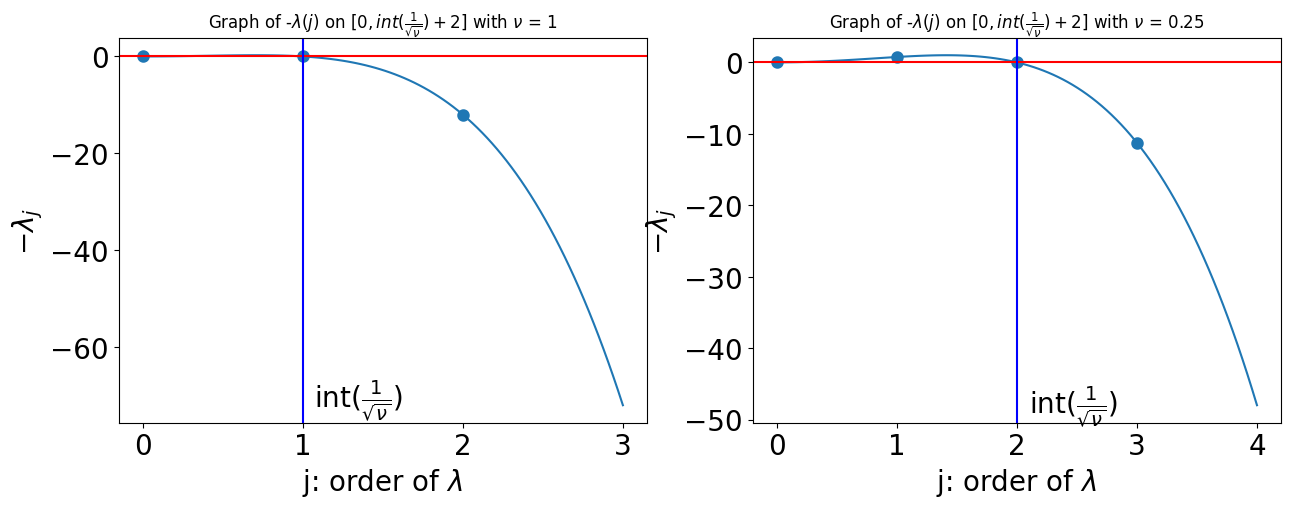

<Figure size 640x480 with 0 Axes>

In [73]:
###Def and visualisation of the lambdas appearing in the ODE (cf LMI or report)

##Definition
def lambda_fct_nu(x, nu):
    return nu*(x**4)-x**2

nu_1, nu_2 = 1, 1/4
lambda_arr_1 = lambda_fct_nu(np.arange(1, M+1), nu=1)
lambda_arr_2 = lambda_fct_nu(np.arange(1, M+1), nu=2)
print("1/sqrt(nu): ", 1/np.sqrt(nu))


##Plot
#Plot of the polynomial -lambda_fct(X). The heighest root is at 1/sqrt(nu)
fig, axs = plt.subplots(1, 2, figsize= (15, 5))
max_k_plot_1, max_k_plot_2 = int(1/np.sqrt(nu_1))+2, int(1/np.sqrt(nu_2))+2
K_1, K_2 = np.linspace(0, max_k_plot_1, 100), np.linspace(0, max_k_plot_2, 100)
N_arr_zoom_1 = np.arange(0, max_k_plot_1)
N_arr_zoom_2 = np.arange(0, max_k_plot_2)
N_arr = np.arange(0, M+1)

#plot and title: 
#The left graph to visualise when the sign change occurs. 
#The right graph to see the total range of the lambdas (all the frequencies)

axs[0].plot(K_1, -lambda_fct_nu(K_1, nu_1))
axs[1].plot(K_2, -lambda_fct_nu(K_2, nu_2))
axs[0].scatter(N_arr_zoom_1, -lambda_fct_nu(N_arr_zoom_1, nu_1), linewidths = 3)
axs[1].scatter(N_arr_zoom_2, -lambda_fct_nu(N_arr_zoom_2, nu_2), linewidths = 3)
# plt.grid()
# axs[1].grid()

axs[0].set_xlabel(r"j: order of $\lambda$")
axs[0].set_ylabel(r"$-\lambda_j$")
axs[0].set_title(r"Graph of -$\lambda(j)$ on $[0,int(\frac{1}{\sqrt{\nu}})+2]$ with $\nu$ = " + "{}".format(nu_1),
                 fontsize=12)

axs[1].set_xlabel(r"j: order of $\lambda$")
axs[1].set_ylabel(r"$-\lambda_j$")
axs[1].set_title(r"Graph of -$\lambda(j)$ on $[0,int(\frac{1}{\sqrt{\nu}})+2]$ with $\nu$ = " + "{}".format(nu_2),
                 fontsize = 12)


#additional things on the graph
axs[0].axhline(y=0, color='r',
                linestyle='-') #draws a line at x=0 to see more clearly the sign of the points
axs[0].axvline(x=int(1/np.sqrt(nu_1)), color='b')
y_min = np.min(-lambda_fct_nu(K_1, nu_1))
print(y_min)
point_graph = np.array([int(1/np.sqrt(nu_1)), y_min])
axs[0].annotate(
    r"int($\frac{1}{\sqrt{\nu}}$)", 
    xy=point_graph, 
    xytext = point_graph + (10, 70),
    textcoords = "offset pixels")

axs[1].axhline(y=0, color='r',
                linestyle='-') #draws a line at x=0 to see more clearly the sign of the points
axs[1].axvline(x=int(1/np.sqrt(nu_2)), color='b')
y_min = np.min(-lambda_fct_nu(K_2, nu_2))
point_graph = np.array([int(1/np.sqrt(nu_2)), y_min])
axs[1].annotate(
    r"int($\frac{1}{\sqrt{\nu}}$)", 
    xy=point_graph, 
    xytext = point_graph + (10, 40),
    textcoords = "offset pixels")

plt.show()
plt.savefig("KS_equation_code")

1/sqrt(nu):  1.0


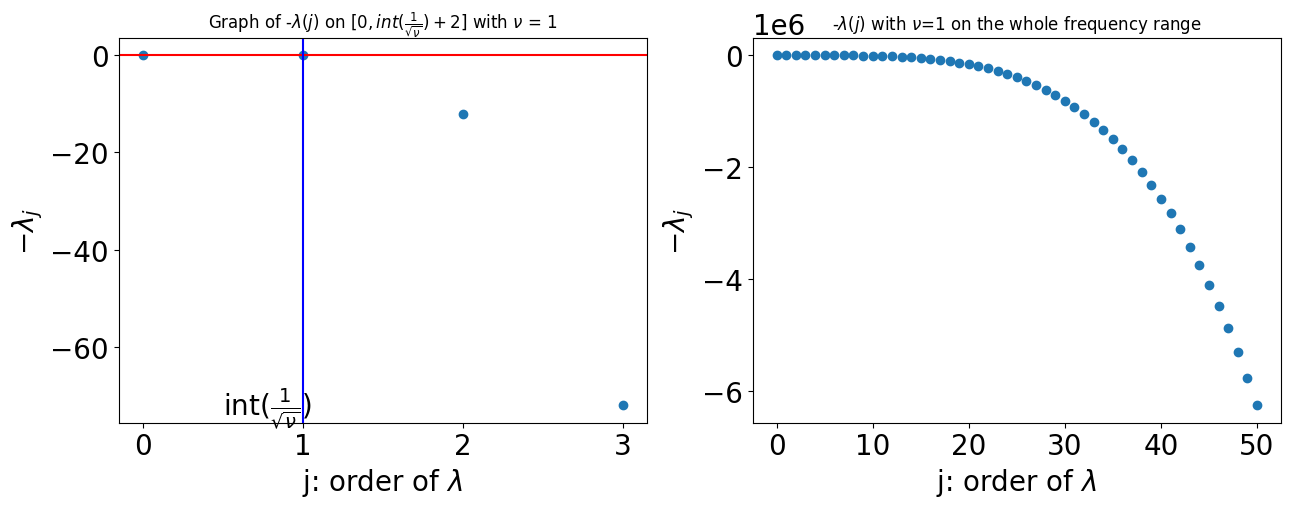

In [74]:
###Def and visualisation of the lambdas appearing in the ODE (cf LMI or report)

##Definition
def lambda_fct(nu, x):
    return nu*(x**4)-x**2

lambda_arr = lambda_fct(nu=nu, x=np.arange(1, M+1))
print("1/sqrt(nu): ", 1/np.sqrt(nu))


##Plot
#Plot of the polynomial -lambda_fct(X). The heighest root is at 1/sqrt(nu)
fig, axs = plt.subplots(1, 2, figsize= (15, 5))
N_arr_zoom = np.arange(0, int(1/np.sqrt(nu))+3)
N_arr = np.arange(0, M+1)

#plot and title: 
#The left graph to visualise when the sign change occurs. 
#The right graph to see the total range of the lambdas (all the frequencies)

axs[0].scatter(N_arr_zoom, -lambda_fct(nu, N_arr_zoom))
axs[1].scatter(N_arr, -lambda_fct(nu, N_arr))

axs[0].set_xlabel(r"j: order of $\lambda$")
axs[0].set_ylabel(r"$-\lambda_j$")
axs[0].set_title(r"Graph of -$\lambda(j)$ on $[0,int(\frac{1}{\sqrt{\nu}})+2]$ with $\nu$ = " + "{}".format(nu)
                 , fontsize = 12)

axs[1].set_xlabel(r"j: order of $\lambda$")
axs[1].set_ylabel(r"$-\lambda_j$")
axs[1].set_title(r"-$\lambda(j)$ with $\nu$" + "={} on the whole frequency range".format(nu), fontsize = 12)


#additional things on the graph
axs[0].axhline(y=0, color='r',
                linestyle='-') #draws a line at x=0 to see more clearly the sign of the points
axs[0].axvline(x=int(1/np.sqrt(nu)), color='b')
y_min, y_max = axs[0].get_ylim() # Get current y-limits
y_coord = y_min + (y_max-y_min)/50 # Set y-coordinate for annotations (e.g., 10% above the bottom)
point_graph = np.array([int(1/np.sqrt(nu)), y_coord])
axs[0].annotate(r"int($\frac{1}{\sqrt{\nu}}$)", xy=point_graph, xytext = point_graph - (0.5, 0))


plt.show()

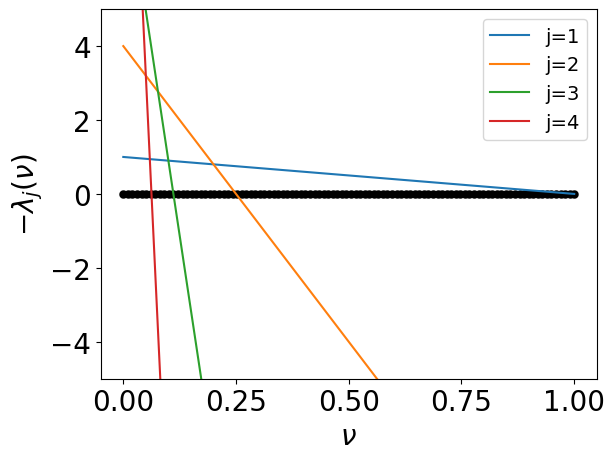

In [75]:
nu_1, nu_2 = 1, 1/4
nu_array = np.linspace(0,1, 100)
lambda_arr_1 = lambda_fct_nu(x=1, nu=nu_array)
lambda_arr_2 = lambda_fct_nu(x=2, nu=nu_array)


for k in range(1, 5):
    plt.plot(nu_array, -lambda_fct_nu(x=k, nu=nu_array), label="j={k}".format(k=k))
plt.scatter(nu_array, np.zeros_like(nu_array), c='k', linewidths=0.1)
plt.ylim(top=5, bottom=-5)
plt.xlabel(r"$\nu$"), plt.ylabel(r"$-\lambda_j(\nu)$")
plt.legend(prop={'size': 14})
# plt.title(r" Plot of $-\lambda_j = -j^2(\nu j^2-1)$ for j $\in [|1,4|]$")
plt.show()

-72.0


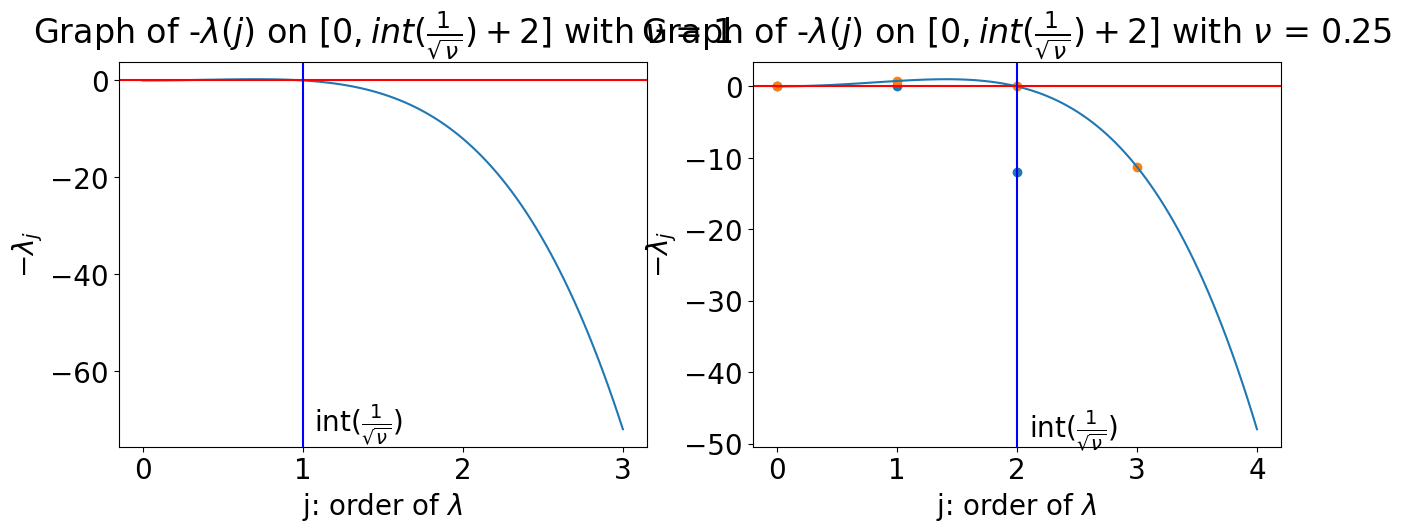

<Figure size 640x480 with 0 Axes>

In [76]:
### Visualisation of the lambdas for a fixed frequency avd varying nu
##Plot
#Plot of the polynomial -lambda_fct(X). The heighest root is at 1/sqrt(nu)
fig, axs = plt.subplots(1, 2, figsize= (15, 5))
# max_k_plot_1, max_k_plot_2 = int(1/np.sqrt(nu_1))+2, int(1/np.sqrt(nu_2))+2
K_1, K_2 = np.linspace(0, max_k_plot_1, 100), np.linspace(0, max_k_plot_2, 100)
N_arr_zoom_1 = np.arange(0, max_k_plot_1)
N_arr_zoom_2 = np.arange(0, max_k_plot_2)
N_arr = np.arange(0, M+1)

#plot and title: 
#The left graph to visualise when the sign change occurs. 
#The right graph to see the total range of the lambdas (all the frequencies)

axs[0].plot(K_1, -lambda_fct_nu(K_1, nu_1))
axs[1].plot(K_2, -lambda_fct_nu(K_2, nu_2))
plt.scatter(N_arr_zoom_1, -lambda_fct_nu(N_arr_zoom_1, nu_1))
axs[1].scatter(N_arr_zoom_2, -lambda_fct_nu(N_arr_zoom_2, nu_2))
# plt.grid()
# axs[1].grid()

axs[0].set_xlabel(r"j: order of $\lambda$")
axs[0].set_ylabel(r"$-\lambda_j$")
axs[0].set_title(r"Graph of -$\lambda(j)$ on $[0,int(\frac{1}{\sqrt{\nu}})+2]$ with $\nu$ = " + "{}".format(nu_1))

axs[1].set_xlabel(r"j: order of $\lambda$")
axs[1].set_ylabel(r"$-\lambda_j$")
axs[1].set_title(r"Graph of -$\lambda(j)$ on $[0,int(\frac{1}{\sqrt{\nu}})+2]$ with $\nu$ = " + "{}".format(nu_2))


#additional things on the graph
axs[0].axhline(y=0, color='r',
                linestyle='-') #draws a line at x=0 to see more clearly the sign of the points
axs[0].axvline(x=int(1/np.sqrt(nu_1)), color='b')
y_min = np.min(-lambda_fct_nu(K_1, nu_1))
print(y_min)
point_graph = np.array([int(1/np.sqrt(nu_1)), y_min])
axs[0].annotate(
    r"int($\frac{1}{\sqrt{\nu}}$)", 
    xy=point_graph, 
    xytext = point_graph + (10, 70),
    textcoords = "offset pixels")

axs[1].axhline(y=0, color='r',
                linestyle='-') #draws a line at x=0 to see more clearly the sign of the points
axs[1].axvline(x=int(1/np.sqrt(nu_2)), color='b')
y_min = np.min(-lambda_fct_nu(K_2, nu_2))
point_graph = np.array([int(1/np.sqrt(nu_2)), y_min])
axs[1].annotate(
    r"int($\frac{1}{\sqrt{\nu}}$)", 
    xy=point_graph, 
    xytext = point_graph + (10, 40),
    textcoords = "offset pixels")

plt.show()
plt.savefig("KS_equation_code")

## Numerical Solving

In [77]:
### Setting up Numerical Scheme Arrays

##Basic schemes (1-2-3): Not described in the report.
#1: Explicit Scheme; 2&3: Implicit Schemes
A1_lambda = np.array([1-dt*lambda_arr[i] for i in range(len(lambda_arr))])
A2_lambda = np.array([(1+dt/nu)/(1+dt*lambda_arr[i]+dt/nu) for i in range(len(lambda_arr))])
B2_lambda = np.array([dt/(1+dt*lambda_arr[i]+dt/nu) for i in range(len(lambda_arr))])
A3_lambda = np.array([1/(1+dt*lambda_arr[i]) for i in range(len(lambda_arr))])


##Scheme in the paper (4)
def alpha_gamma_coef(_p):
    '''
    Gives the coefficient of the polynomials alpha and gamma (cf appendix of LMI paper). 
    - Input: _p: order of the scheme
    - Output: (alpha_coef, gamma_coef) tuple of 2 np.array of shape (p,) and (p-1,) respectively.'''
    match _p:
        case 1:
            return (np.array([-1, 1]), np.array([1]))
        case 2:
            return (np.array([1/2, -2, 3/2]), np.array([-1, 2]))
        case 3:
            return (np.array([-1/3, 3/2, -3, 11/6]), np.array([1, -3, 3]))
        case 4:
            return (np.array([1/4, -4/3, 3, -4, 25/12]), np.array([-1, 4, -6, 4]))
        case 5:
            return (np.array([-1/5, 5/4, -10/3, 5, -5, 137/60]), np.array([1, -5, 10, -10, 5]))
        case 6:
            return (np.array([1/6, -6/5, 15/4, -20/3, 15/2, -6, 147/60]), np.array([-1, 6, -15, 20, -15, 6]))
        case _:
            raise Exception("Function alpha_gamma_coef: Error in the calculus, wrong p value.")


p=6 #Order of the numerical scheme
alpha_coef, gamma_coef = alpha_gamma_coef(p)

A4_lambda = 1/((alpha_coef[-1]+dt/nu)*np.ones(M)+dt*lambda_arr) #prblm here
B4_lambda = (dt/nu*gamma_coef - alpha_coef[:-1])
Uc4_mat = np.zeros((N_t, len(u_c)))
Us4_mat = np.zeros((N_t, len(u_s)))
Uc4_mat[0,:] = u_c
Us4_mat[0,:] = u_s
Fc4_mat = np.zeros((N_t, len(u_c)))
Fs4_mat = np.zeros((N_t, len(u_s)))

In [78]:
##Calculus
t_i = time.time() #measuring the time for speed evalutation
print("nu: ", nu)

if bool_calculus_Fourier:
    if bool_scheme_paper: #Scheme of the paper
        for n_t in range(1, p): #Implicit-Explicit method until (p-1)dt
            Fc4_mat[n_t-1], Fs4_mat[n_t-1] = F(Uc4_mat[n_t-1], Us4_mat[n_t-1])
            Uc4_mat[n_t] = A2_lambda*Uc4_mat[n_t-1] + B2_lambda*Fc4_mat[n_t-1]
            Us4_mat[n_t] = A2_lambda*Us4_mat[n_t-1] + B2_lambda*Fs4_mat[n_t-1]
            u_Fourier_mat[n_t, 1:] = (Uc4_mat[n_t] - (1j)*Us4_mat[n_t])/2
            
        for n_t in range(0, N_t-p):
            Fc4_mat[n_t+p-1], Fs4_mat[n_t+p-1] = F(Uc4_mat[n_t+p-1], Us4_mat[n_t+p-1])
            Uc4_mat[n_t+p] = A4_lambda*(B4_lambda@Uc4_mat[n_t:n_t+p] 
                                        + dt*gamma_coef@Fc4_mat[n_t:n_t+p]) #Indexes from n_t to n_t+p-1
            Us4_mat[n_t+p] = A4_lambda*(B4_lambda@Us4_mat[n_t:n_t+p] + dt*gamma_coef@Fs4_mat[n_t:n_t+p])
            u_Fourier_mat[n_t+p, 1:] = ( Uc4_mat[n_t+p] - (1j)* Us4_mat[n_t+p])/2 

            
    else: #One of the 3 other scheme 
        if bool_scheme_1: #1 Scheme: Fully explicit  
            for n_t in range(1, N_t):
                F_c, F_s = F(u_c, u_s)
                u_c = A1_lambda*u_c + dt*F_c
                u_s = A1_lambda*u_s + dt*F_s
                u_Fourier_mat[n_t, 1:] = (u_c - (1j)*u_s)/2 
                #Not taking the first element as it is the mean value supposed to be zero.

        elif bool_scheme_2: #2 Scheme: Implicit-Explicit
            for n_t in range(1, N_t):
                F_c, F_s = F(u_c, u_s)
                u_c = A2_lambda*u_c + B2_lambda*F_c
                u_s = A2_lambda*u_s + B2_lambda*F_s
                u_Fourier_mat[n_t, 1:] = (u_c - (1j)*u_s)/2 

        elif bool_scheme_3: #3 Scheme: A bit more Implicit
            for n_t in range(1, N_t):
                F_c, F_s = F(u_c, u_s)
                u_c = A3_lambda*u_c + dt*A3_lambda*F_c
                u_s = A3_lambda*u_s + dt*A3_lambda*F_s
                u_Fourier_mat[n_t, 1:] = (u_c - (1j)*u_s)/2 


t_f = time.time()

#Some checks
computation_time = t_f-t_i 
print("Computation duration: ", int(computation_time*100)/100)
print("number of non nan: ", np.count_nonzero(np.isnan(u_Fourier_mat)))
print("Maximum of the Fourier coef:", np.max(np.nan_to_num(u_Fourier_mat)), "\n")


# if save:    
#     np.savetxt('KS_eq_Fourier.txt', h_Fourier_mat, fmt='%d')
# else:
#     h_Fourier_mat = np.loadtxt('KS_eq_Fourier.txt', dtype=complex)

nu:  1
Computation duration:  20.29
number of non nan:  0
Maximum of the Fourier coef: (9.270362255620057e-17-0.5j) 



In [79]:
### Back to the height h with inverse FFT
for n_t in range(1, N_t):
    u_mat[n_t, :] = np.fft.irfft(u_Fourier_mat[n_t, :], norm="forward") #Same norm as the direct fft

# Animations & Results

## Animations

In [80]:
bool_anim_Fourier = True #Compute & display the animation or not

In [81]:
#animation function
def func_anim_1(_time_series, _anim_space_array, _anim_time_array,
                 title, title_x_axis = None, title_y_axis= None, _legend_list = None,
                 bool_grid = False, _x_ticks_major = None):
    
    '''inputs:
        _time_series :The space-time functions. There can be many   ((N, N_t, N_x) array)
        _anim_space_array, _anim_time_array: time domain ((N_t) array), space domain ((N_x) array)
        title, title_x_axis, title_y_axis: explicit
        _legend_list: list of the legend of the graph corresponding to the space-time functions
        bool_grid: put a grid or not
        _x_ticks_major: display some specific values on the x-axis
        '''
    


    #(Nb_tab, N_t, N_x) tab
    Nb_time_series =  _time_series.shape[0]
    gap = (_time_series.max()- _time_series.min())/10

    #subplot initialisation
    fig, axs = plt.subplots(1, 1, figsize=(10, 4))


    # Initialise the plot ligns
    array_line_analytical = Nb_time_series*[0]
    for k in range(Nb_time_series):
        if not(_legend_list is None):
            array_line_analytical[k], = axs.plot([], [], label=_legend_list[k])
        else:
            array_line_analytical[k], = axs.plot([], [])

    axs.set_xlim([_anim_space_array.min(), _anim_space_array.max()])
    axs.set_ylim([_time_series.min()-gap, _time_series.max()+gap])

    if bool_grid:
        if _x_ticks_major is None:
            axs.set_xticks(_anim_space_array, minor=True)
            axs.grid(which='both')  # Major ticks for x-axis, every 1 unit
        else:
            axs.set_xticks(_x_ticks_major) #Major xticks : the one which is showed on the x axis
            axs.set_xticks(_anim_space_array, minor=True) #minor xticks
            axs.grid(which='both') #grid for the minor tick

    # Update the function in the animation
    def update(frame):
        t_1 = _anim_time_array[frame]
        y = np.array([_time_series[k][frame] for k in range(Nb_time_series)])
        for k in range(_time_series.shape[0]):
            array_line_analytical[k].set_data(_anim_space_array, y[k])
        
        axs.set_title(title + ' at t= {}'.format(t_1))
        axs.set_xlabel(title_x_axis)
        axs.set_ylabel(title_y_axis)

        if not(_legend_list is None):
            axs.legend()
        return array_line_analytical,

    # Create the animation
    # plt.close() #To avoid having another plot after the animation

    return FuncAnimation(fig, update, frames=len(_anim_time_array)-1)  



In [82]:
img_per_step = 25*8 #(total number of image)/(nb of image displayed) ratio. 
N_t_anim = int(N_t/img_per_step)

u_anim = np.array([u_mat[i] for i in range(len(u_mat)) if i%img_per_step==0])
print(u_anim.shape, u_mat.shape)


(50, 100) (10000, 100)


In [83]:
u_c_total = 2*u_Fourier_mat[:, 1:].real  #See the Obsidian file for justification.
u_s_total = -2*u_Fourier_mat[:, 1:].imag 
Time_array = np.linspace(start=0, stop=T, num=N_t, endpoint=True)


if bool_anim_Fourier:
    Time_array_anim = np.linspace(start=0, stop=T, num=N_t_anim, endpoint=True)
    # anim = func_anim(h_anim, dt_anim=dt_anim, title="Fourier numerical scheme: h(x, t)", title_x_axis="x axis", title_y_axis="height h(x, t)")
    # display(anim)
    anim_1 = func_anim_1(np.array([u_anim]), _anim_space_array=Domain_x, _anim_time_array = Time_array_anim,
                            title="Fourier numerical scheme: u(x, t)", title_x_axis="x axis", 
                            title_y_axis="u(x, t)")
    # anim_1.save("anim_KS_equation_Progressive_wave.mp4")
    display(HTML(anim_1.to_jshtml()))
    plt.close()

    #plot of the IC in frequency domain
    u_c_total_anim = np.array([u_c_total[i] for i in range(len(u_mat)) if i%img_per_step==0])
    u_s_total_anim = np.array([u_s_total[i] for i in range(len(u_mat)) if i%img_per_step==0])
    
    #Animation of the Fourier coefficient
    anim_1 = func_anim_1(np.array([u_c_total_anim, u_s_total_anim]), _anim_space_array=fq_tab[1:], _anim_time_array = Time_array_anim,
                            title="Fourier spectrum (visualisation of dominant modes)", title_x_axis="number of the Fourier coef", 
                            title_y_axis="Fourier coefficients", _legend_list=["Cos", "Sin"],
                            bool_grid=True, _x_ticks_major = np.array([fq_tab[1]]+[fq_tab[i] for i in range(1, len(fq_tab)) if i%5==0]))
    display(HTML(anim_1.to_jshtml()))
    plt.close()
    


## Results & Analysis

### Visualisation of the different regimes

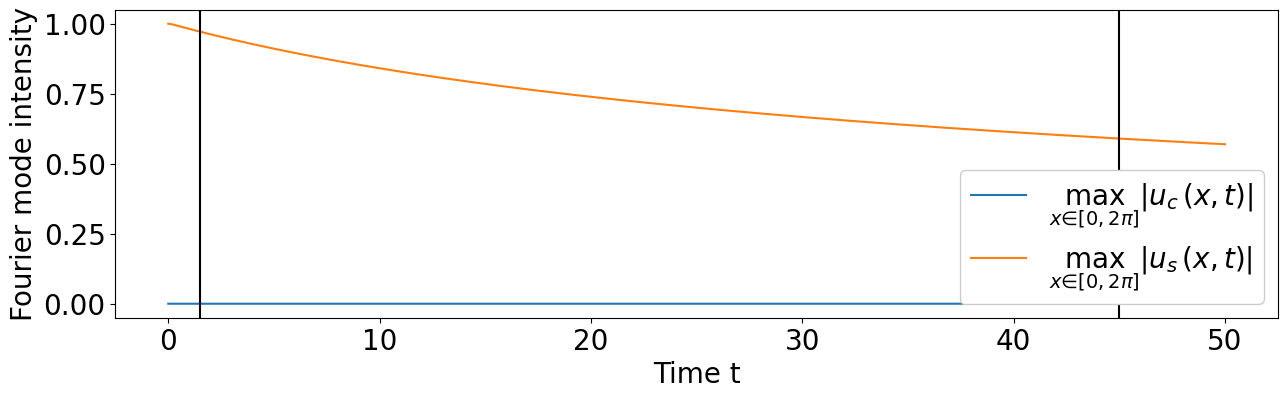

In [84]:
##Graph of the predominant Fourier cos and sin modes  
#I display the extrema with their respective sign (i.e not in absolute value) to spot the periodic behavior 
#which could be hidden/modified with absolute values (e.g having  f(fq, time) =f(1, 0) = 1, f(1, pi) = -1, f(1, 2pi) = 1  )

fig = plt.figure(figsize=(15, 4))
uc_dom_indx_1 = np.argmax(np.absolute(u_c_total), axis=1)
us_dom_indx_1 = np.argmax(np.absolute(u_s_total), axis=1)

u_c_dominant = [u_c_total[i, uc_dom_indx_1[i]] for i in range(N_t) ]
u_s_dominant = [u_s_total[i, us_dom_indx_1[i]] for i in range(N_t) ]


plt.plot(Time_array, np.absolute(u_c_dominant), label=r"$\max_{x\in [0,2\pi]}|u_c(x,t)|$")
plt.plot(Time_array, np.absolute(u_s_dominant), label=r"$\max_{x\in [0,2\pi]}|u_s(x,t)|$")
plt.xlabel("Time t")
plt.ylabel("Fourier mode intensity")

# plt.axhline(y=0, color= "0", linestyle='-') #draws a line at x=0 to see more clearly the sign of the points
plt.axvline(x=1.5, c='k'), plt.axvline(x=45, c='k')

# plot_title = "Dynamics of the extrema of the Fourier coefficients: \n max|u_s(.,t)|, max|u_c(.,t)| with k={k}, ".format(k=mode_fq)
# plot_title = "Dynamics of the extrema of the Fourier coefficients"
# plot_title += r"with $\nu$="
# plot_title += "13/48 ".format(nu=nu)
# plt.yscale('log')
# plt.title(plot_title)
plt.legend(loc = "lower right", framealpha = 1)
plt.show()

Study of $u_{max}$: Visualisation and slope measurements.

We study the log scale of $u_{max}$ with a modal Initial condition i.e a sin(kx) or cos(kx). 
- For the dampening case, we compare it to the regime without the linearity which is an exponential one. We make the linear regression of $log(u_{max}) = log(u_{max}(0)e^{-\lambda_k t}) = log(u_{max}(0)) -  \lambda_k t$. We then compare the coefficient a and b from the linear regression y = ax+b to $-\lambda_k$ and $log(u_{max}(0))$ respectively.

In [93]:
###Computation of u_max

u_max = np.max(np.absolute(u_mat), axis=1)


###Computation of the border times
# Goal: see the limits of the regimes (linear, wave,...) with the derivative (code changes depending on the result graph) 

u_max_log_derivative = np.gradient(np.log(u_max), dt) # Compute the derivative using finite difference
u_max_log_derivative_2 = np.gradient(u_max_log_derivative, dt)


##Method of computation, downsides & Alternative method: 
#Finding/defining the border times by the moments when the derivative is null: downside, yields bad results in the linear regression as I go further the line.
#I would like to use when second derivative != 0 (i.e a curve change) but the 2nd der. seems to unstable numerically

k_1, k_2 = 0, 0
counter = 0
for k in range(len(Time_array)):
    if abs(u_max_log_derivative[k]) <= 1e-3 and counter!=0:
        k_2 = k
        break
    elif abs(u_max_log_derivative[k]) <= 1e-3: #counter = 0 then
        k_1=k
        counter+=1


# t_1, t_2 = k_1*dt, k_2*dt
t_1, t_2 = 0, T
print(u_max_log_derivative)
print(t_1, t_2)



[ 0.         -0.00187388 -0.0051759  ... -0.00678111 -0.00678065
 -0.00678042]
0 50


In [94]:
#Linear regression
t_1_reg, t_2_reg = t_1, t_2, # Better results when I take t_1 t_2 not in the border of the linear regime. 
N_1, N_2 = int(t_1_reg/T*N_t), int(t_2_reg/T*N_t)
x_lin_reg_array = Time_array[N_1:N_2].reshape(-1,1) #Necessary reshape for sklearn
y_lin_reg_array = np.log(u_max[N_1:N_2]).reshape(-1, 1)


reg = LinearRegression(fit_intercept=True).fit(x_lin_reg_array, y_lin_reg_array) #sklearn function

Reg_lin_coef_a , Reg_lin_coef_b= reg.coef_[0][0], reg.intercept_[0]
Reg_lin_coef_r_sq = reg.score(x_lin_reg_array, y_lin_reg_array)
print("Slope coefficient(s) ax+b:", Reg_lin_coef_a, Reg_lin_coef_b)
print("Determination coefficient R²: ",Reg_lin_coef_r_sq)

Slope coefficient(s) ax+b: -0.010863459460464188 -0.05974555769355877
Determination coefficient R²:  0.9797361434901788


In [95]:
exp_rate = -lambda_fct_nu(nu=nu, x=mode_fq)
print(Reg_lin_coef_a, exp_rate)
print(np.exp(Reg_lin_coef_b), u_max[0])

print("\nrelative error for the decay rate: ", 
      np.abs(Reg_lin_coef_a-exp_rate)/np.abs(exp_rate)*100, "%")
print("relative error for the initial condition: ", 
      np.abs(np.exp(Reg_lin_coef_b)-u_max[0])/np.abs(u_max[0])*100, "%")

-0.010863459460464188 0
0.9420041888122199 1.0

relative error for the decay rate:  inf %
relative error for the initial condition:  5.799581118778008 %


C:\Users\Bilal_BM_user\AppData\Local\Temp\ipykernel_32048\1927443908.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  np.abs(Reg_lin_coef_a-exp_rate)/np.abs(exp_rate)*100, "%")


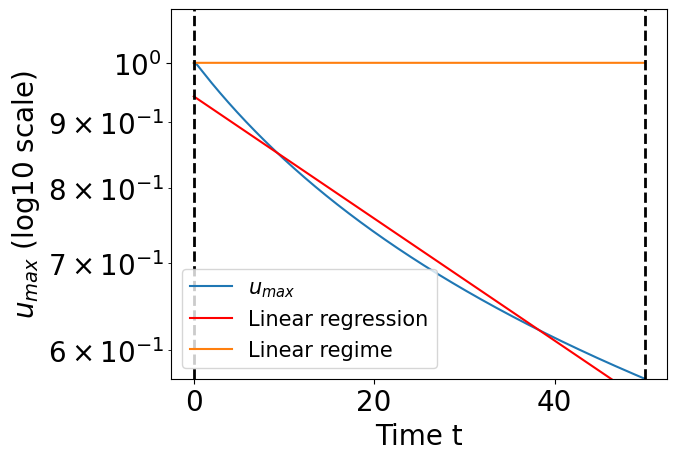

In [103]:
##Plot of h_max and its derivatives
#I display h_max to visualise the change in the system

# fig, axs = plt.subplots(3, 1, figsize=(10, 16))
plt.rc('font', size=20) # Set the font size for all the plots 

plt.plot(Time_array, u_max, label=r'$u_{max}$')
plt.plot(Time_array, np.exp(Reg_lin_coef_a*Time_array+Reg_lin_coef_b), color='r', label='Linear regression')
# plt.plot(Time_array,  10**(Reg_lin_coef_b_L2)*(dx_array**Reg_lin_coef_a_L2)), color
plt.plot(Time_array, u_max[0]*np.exp(-lambda_fct_nu(nu=nu, x=mode_fq)*Time_array), label="Linear regime")
plt.axvline(x=t_1, color='0', linestyle='--', linewidth=2)
plt.axvline(x=t_2, color='0', linestyle='--', linewidth=2)
plt.ylim(np.min(u_max), np.max(u_max)+0.1)


plt.xlabel("Time t")
plt.ylabel(r"$u_{max}$ (log10 scale)")
plt.yscale("log")# plt.title(r"Dynamics of $u_{max}$ in log10 scale, $\nu=$"+"{nu},k={mode}".format(nu=nu, mode=mode_fq))
plt.legend(loc="lower left", fontsize=15)


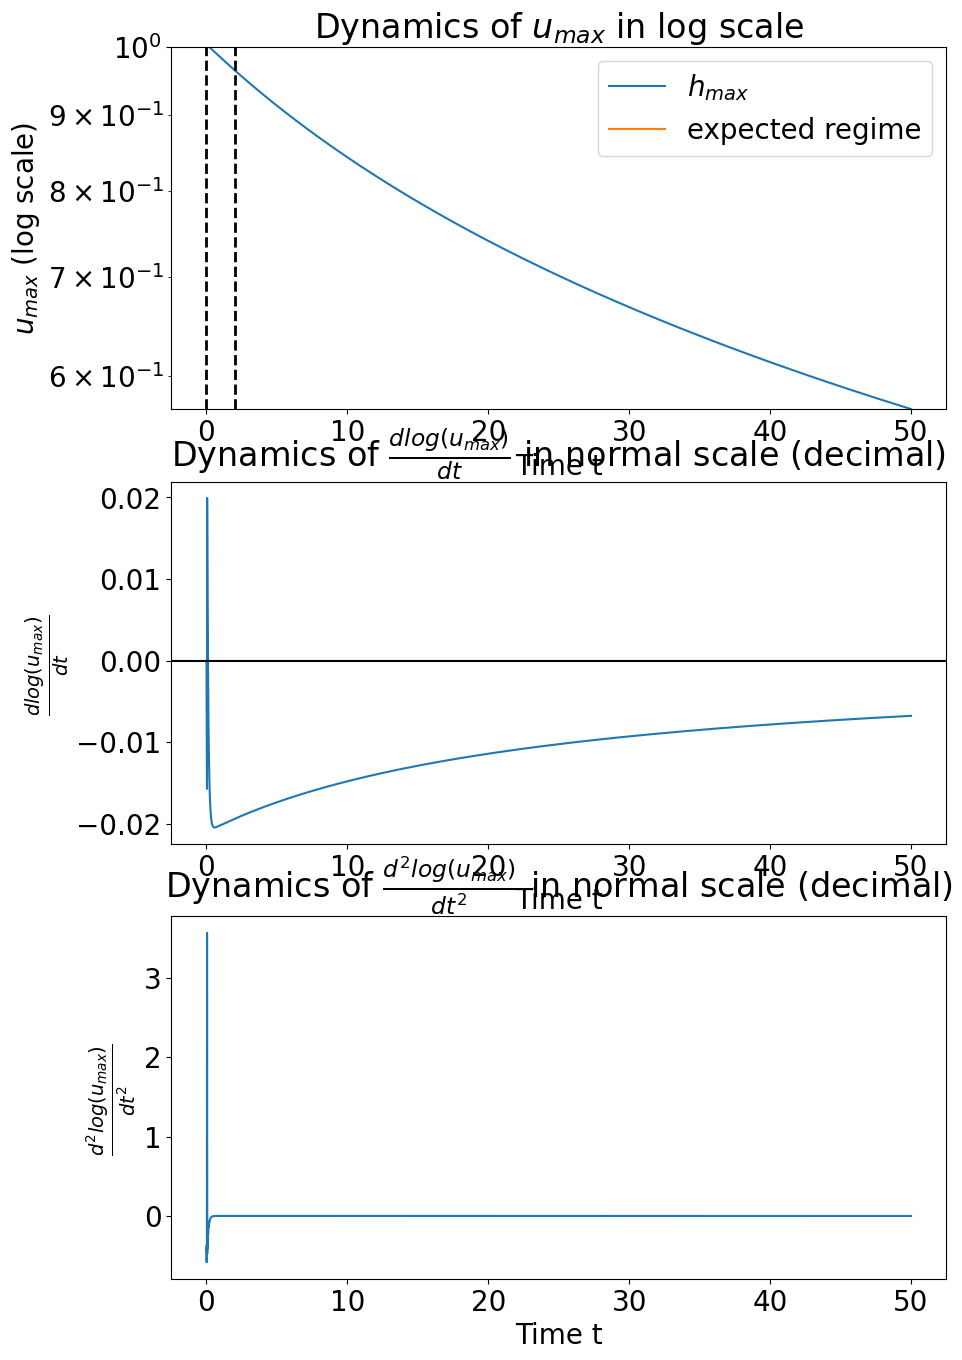

In [89]:
##Plot of h_max and its derivatives
#I display h_max to visualise the change in the system

fig, axs = plt.subplots(3, 1, figsize=(10, 16))

axs[0].plot(Time_array, u_max, label=r'$h_{max}$')
# axs[0].plot(Time_array, np.exp(Reg_lin_coef_a*Time_array+Reg_lin_coef_b), color='r', label='Linear_reg')
# axs[0].plot(TIme_array,  10**(Reg_lin_coef_b_L2)*(dx_array**Reg_lin_coef_a_L2)), color
axs[0].plot(Time_array, u_max[0]*np.exp(-lambda_fct_nu(nu=nu, x=mode_fq)*Time_array), label="expected regime")
axs[0].axvline(x=t_1, color='0', linestyle='--', linewidth=2)
axs[0].axvline(x=t_2, color='0', linestyle='--', linewidth=2)
axs[0].set_ylim(np.min(u_max), np.max(u_max))


axs[0].set_xlabel("Time t")
axs[0].set_ylabel(r"$u_{max}$ (log scale)")
axs[0].set_yscale("log")
axs[0].legend()
axs[0].set_title(r"Dynamics of $u_{max}$ in log scale")


axs[1].plot(Time_array, u_max_log_derivative)
axs[1].axhline(y=0, color= "0", linestyle='-') 
axs[1].set_xlabel("Time t")
axs[1].set_ylabel(r"$\frac{dlog(u_{max})}{dt}$ ")
axs[1].set_title(r"Dynamics of $\frac{dlog(u_{max})}{dt}$ in normal scale (decimal)")

axs[2].plot(Time_array, u_max_log_derivative_2)
axs[2].set_xlabel("Time t")
# axs[2].set_xlim(5, 25)
axs[2].set_ylabel(r"$\frac{d^2log(u_{max})}{dt^2}$ ")   
axs[2].set_title(r"Dynamics of $\frac{d^2log(u_{max})}{dt^2}$ in normal scale (decimal)")

plt.show()

### Linear System & caracteristic decay time

In [90]:
#Theoretical time array initialisation & Computation of experimental characteristic time 

carac_time_array = 1/lambda_arr[1:] # withdraw the cases where lambda <=0
max_u_array = np.max(np.absolute(u_mat), axis=1)
idx_decay_time = -1

#Measurement of 5*caracteristic decay time. Reminder: 0.01%(~ exp(-5tau)) of the amplitude of the signal is reached at 5tau.
for k in range(len(max_u_array)):
    if max_u_array[k] < 0.01:
        idx_decay_time = k
        break

print("theoretical carac_time:", carac_time_array)
print(dt*idx_decay_time)

theoretical carac_time: [8.33333333e-02 1.38888889e-02 4.16666667e-03 1.66666667e-03
 7.93650794e-04 4.25170068e-04 2.48015873e-04 1.54320988e-04
 1.01010101e-04 6.88705234e-05 4.85625486e-05 3.52211891e-05
 2.61643119e-05 1.98412698e-05 1.53186275e-05 1.20146098e-05
 9.55547911e-06 7.69467528e-06 6.26566416e-06 5.15357658e-06
 4.27767226e-06 3.58022570e-06 3.01932367e-06 2.56410256e-06
 2.19154065e-06 1.88426114e-06 1.62900409e-06 1.41554838e-06
 1.23594117e-06 1.08394034e-06 9.54606549e-07 8.44001512e-07
 7.48962687e-07 6.66933440e-07 5.95833929e-07 5.33962127e-07
 4.79917377e-07 4.32540918e-07 3.90869293e-07 3.54097618e-07
 3.21550439e-07 2.92658486e-07 2.66940013e-07 2.43985751e-07
 2.23446710e-07 2.05024242e-07 1.88461910e-07 1.73538803e-07
 1.60064026e-07]
-0.005000500050005001


In [91]:
#Exp. measurement of 5tau with initial condition : Sin(2pifx) with f in range(2, 11). We devide by 5 to have tau

#nu = 1; fq in range(2, 11)
exp_carac_time_array_1 = (1/5)*np.array([0.38375000000000004, 0.06399, 0.019195, 0.007678, 0.0036544999999999998, 0.0019595, 0.001143, 0.0007109999999999999, 0.00046039999999999997])
#nu=1/2
exp_carac_time_array_2 = (1/5)*np.array([1.152, 0.14624, 0.04113000000000001, 0.016026000000000002, 0.0075239999999999994, 0.0040005, 0.0023211, 0.0014399999999999999 , 0.0009299999999999999])

#nu=1/4
# exp_carac_time_array_2 = (1/5)*np.array([1.152, 0.14624, 0.04113000000000001, 0.016026000000000002, 0.0075239999999999994, 0.0040005, 0.0023211, 0.0014399999999999999 , 0.0009299999999999999])

relative errors in % compared to the linear theory for the 10 first tau: [176.48     110.5856    97.424     92.312     89.6048    88.18352
  87.173504  86.624     84.14    ]
mean and standard deviation:  101.39193600000002 27.592701195093753


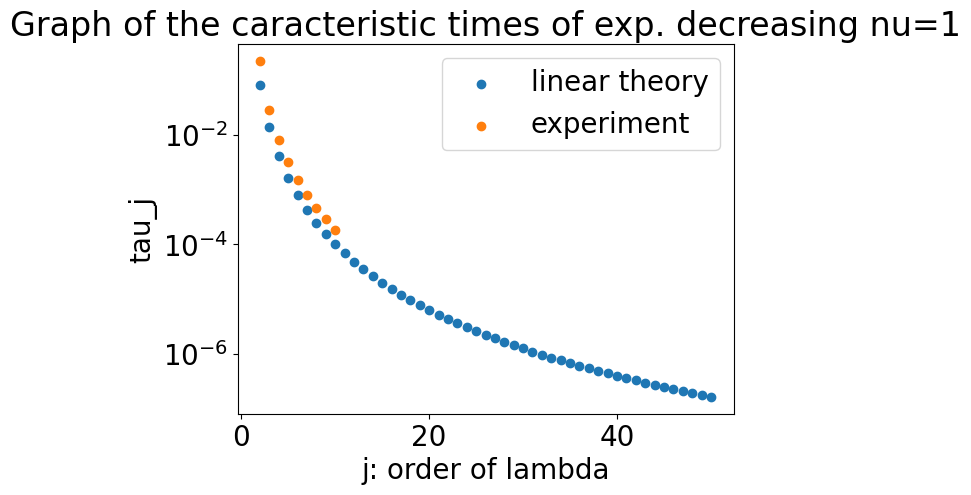

In [92]:
##Visualisation of experimental and theoretical tau. Comparison with relative error.

arr_tau_errors = 100*np.absolute(exp_carac_time_array_2-carac_time_array[:9])/carac_time_array[:9]
print("relative errors in % compared to the linear theory for the 10 first tau:", arr_tau_errors)
print("mean and standard deviation: ", np.mean(arr_tau_errors), np.std(arr_tau_errors))

plt.scatter(np.arange(2, M+1), carac_time_array, label = "linear theory")
plt.scatter(np.arange(2, 10+1), exp_carac_time_array_2, label = "experiment")

plt.legend()
plt.xlabel("j: order of lambda")
plt.ylabel("tau_j")
plt.yscale("log")
plt.title("Graph of the caracteristic times of exp. decreasing nu={}".format(nu))
plt.show()